# Time Series Analysis and Text Classification Algorithms
### Dataset: 100,000 Amazon Product Reviews
##### Chloe Sheen

In this project, we analyze a dataset of Amazon reviews comprised of text, timestamps, and star ratings. Herein, we start with time analyses to explore trends in star ratings, and follow with a survey of different text classification algorithms. 

In [0]:
# install install install
%%capture
!pip install -U gensim
!pip install urllib2

In [0]:
# checking gensim version
import gensim
gensim.__version__

'3.8.1'

In [0]:
# import more stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors, Word2Vec
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf

import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression

from datetime import *
from operator import itemgetter


In [0]:
# getting the datasets 
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

In [0]:
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

## Part 0: Time Series Analysis

Prior to extraction of text features, we pick up on previous classwork centered around time analyses in order to discover additional trends in the star rating data.

In [0]:
# convert_times from homework 4
def convert_times(reviews_times):
  times = []
  for i in reviews_times:
    times.append(datetime.fromtimestamp(i))
  return pd.Series(times)

In [0]:
converted_times = convert_times(reviews_times)

In [0]:
times = pd.DataFrame(converted_times)
rating = pd.DataFrame(y)
data = pd.concat([times, rating], axis=1)
data.columns = ['times', 'rating']
data = data.set_index('times').sort_index()

In [0]:
years = data.groupby(pd.Grouper(freq="Y"))
total_reviews_per_year = years.sum()
total_reviews_per_year.reset_index(level=0, inplace=True)

In [0]:
# to remove the python FutureWarning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

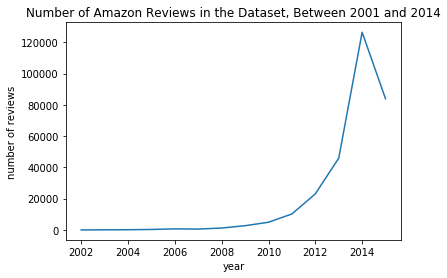

In [0]:
fig, ax = plt.subplots()
ax.plot(total_reviews_per_year['times'], total_reviews_per_year['rating'])
ax.set(xlabel='year', ylabel='number of reviews',
       title='Number of Amazon Reviews in the Dataset, Between 2001 and 2014')
plt.show()

As expected, the number of total reviews on Amazon has increased exponentially over this time period. To aid us in drawing more statistically accurate conclusions, we continued our analysis of star rating data by using the averages per month and averages per year.


In [0]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt

time_star=pd.Series(y,index=converted_times).rename_axis('time')

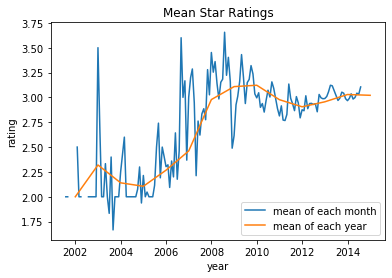

In [0]:
plt.title('Mean Star Ratings')
plt.plot(time_star.resample('M').apply(np.mean), label='mean of each month')
plt.plot(time_star.resample('A').apply(np.mean), label='mean of each year')
plt.ylabel('rating')
plt.xlabel('year')
plt.legend(loc='best')
plt.show()

This is interesting! These findings are more more quantifiable, indicating an increase of a whole star rating within one decade. To follow this finding up, we calculated rolling statistics data to smooth out short-term fluctuations, which will facilitate our exploration of longer-term trends of average star ratings over time.

In [0]:
data_series= pd.Series(data.iloc[:, 0])
data_series

times
2001-07-17    2
2001-07-25    2
2001-08-24    2
2002-01-01    5
2002-01-05    1
             ..
2014-07-22    4
2014-07-22    5
2014-07-22    5
2014-07-23    5
2014-07-23    4
Name: rating, Length: 100000, dtype: int64

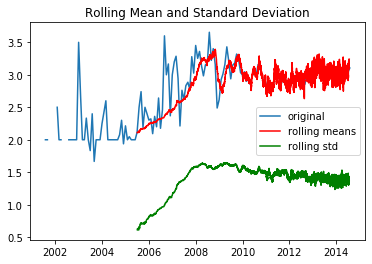

In [0]:
rmean = data_series.rolling(window=365).mean()
rstd = data_series.rolling(window=365).std()
plt.plot(data_series.resample('M').apply(np.mean), label ='original')
plt.plot(rmean, color='red', label ='rolling means')
plt.plot(rstd, color = 'green', label = 'rolling std')
plt.legend(loc='best')
plt.title("Rolling Mean and Standard Deviation")
plt.show(block=False)

Here, the first element of the moving average is the average of the initial subset of size *n* of the series, and the subset gets modified by shifting forward. 

Note that the trend of an exponential spike in average ratings in reviews between the year 2005 and 2008 remains the same even when smoothing the plot. Upon further investigation, we can attest that this upward trend can be attributed in part to the influence of review bots writing artificial positive reviews.

Further, I will attempt to make the time series more stationary by differencing. 

In [0]:
time_star.head()

time
2012-05-06    1
2014-04-07    1
2012-07-17    1
2014-07-14    1
2013-05-16    1
dtype: int64

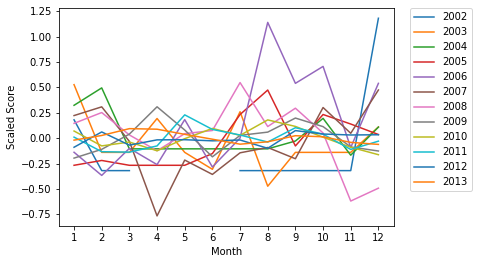

In [0]:
month_star = time_star.resample('M').mean()

for year in range(2002,2014):
    months = range(1,13)
    year_mean = time_star.resample('A').apply(np.mean)[str(year)].values[0]
    plt.plot(months, month_star[str(year)]-year_mean, label=str(year))
plt.xlabel('Month')
plt.ylabel('Scaled Score')
plt.xticks(np.arange(min(months), max(months)+1, 1.0))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

We have a plot of the average star ratings of each month subtracted by the average star ratings of the corresponding year. I was hoping to see whether the average ratings universally increase towards the holiday season, but it unfortunately there isn't much to be gained from this plot. 



## **Part 1: Topic Modeling**

Topic modeling extracts topics from large volumes of text. The next analysis I wanted to perform on this dataset was whether I could find groupings of the reviews that would reveal the categories that these reviews belong to. 

We'll create a LsiModel first to perform topic modeling. This is found in the gensim library. We'll start with 10 topics and see what the output of `print_topics()` looks like. This provides the top 10 most significant topics.

In [0]:
max_cutoff = 10

lsi_model = LsiModel(reviews_bow, id2word=reviews_dict, num_topics=max_cutoff)  # train model

In [0]:
lsi_model.print_topics()

[(0,
  '0.333*"use" + 0.250*"one" + 0.228*"like" + 0.208*"get" + 0.193*"just" + 0.181*"can" + 0.165*"will" + 0.147*"work" + 0.143*"time" + 0.128*"product"'),
 (1,
  '-0.822*"magnesium" + -0.234*"mg" + -0.186*"per" + -0.149*"citrat" + -0.123*"chelat" + -0.107*"capsul" + -0.103*"price" + -0.102*"cap" + -0.095*"food" + -0.089*"gel"'),
 (2,
  '-0.543*"dog" + 0.539*"use" + -0.290*"food" + -0.220*"cat" + -0.158*"like" + 0.136*"seat" + -0.134*"one" + 0.125*"babi" + -0.123*"toy" + -0.120*"treat"'),
 (3,
  '-0.457*"use" + 0.434*"seat" + -0.255*"dog" + -0.213*"cat" + -0.198*"product" + 0.186*"one" + 0.180*"stroller" + 0.162*"fit" + 0.159*"car" + 0.137*"babi"'),
 (4,
  '0.557*"dog" + 0.487*"seat" + -0.263*"cat" + 0.242*"use" + -0.221*"one" + 0.189*"car" + 0.144*"babi" + 0.130*"stroller" + 0.128*"food" + -0.121*"size"'),
 (5,
  '0.704*"cat" + 0.354*"seat" + 0.258*"litter" + -0.213*"dog" + 0.177*"box" + -0.159*"size" + 0.150*"food" + 0.130*"car" + -0.103*"shoe" + -0.095*"wear"'),
 (6,
  '0.428*"pum

We can deduce topics from this:
* Topic 0: product that works
* Topic 1: magnesium capsule
* Topic 3: dog/cat/baby stroller
* Topic 4: dog/cat/baby stroller
* Topic 5: dog/cat litter
* Topic 6: baby bottles
* Topic 7: diaper/bottle bags
* Topic 8: baby/dog monitor
* Topic 9: diaper bag

The natural question is then: what *is* the best number of topics to choose so that the topics do not overlap? We can use gensim's CoherenceModel to calculate a coherence score, which calculates whether topics overlap with each other. 

Below, we calculate the coherence values to determine how many topics would be most suitable for our dataset. 

In [0]:
from gensim.models.coherencemodel import CoherenceModel 

In [0]:
def create_lsa(doc, dict, num_topics):
  return LsiModel(reviews_bow, id2word=reviews_dict, num_topics=num_topics) 

In [0]:
def run_lsa(doc, num_topics=10):
  dictionary = reviews_dict
  lsa = create_lsa(doc, dictionary, num_topics)
  return doc, dictionary, lsa

In [0]:
def coherence_score(doc, dict, model):  
  coherence_model = CoherenceModel(model=lsi_model, corpus=reviews_bow, dictionary=reviews_dict, coherence='u_mass')
  return coherence_model.get_coherence()

In [0]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [0]:
def coherence_values(low, high):
  res = []
  for n_topics in range(low, high):
    doc, dictionary, model = run_lsa(reviews_bow, num_topics=n_topics)  # train model
    coherence = coherence_score(doc, dictionary, model)
    res.append(coherence)
  return res
l = max(coherence_values(1, 20))

So this is nice, but using an LSI model can lead to overfitting on the training data: [read stackexchange discussion](https://stats.stackexchange.com/questions/106121/does-it-make-sense-to-combine-pca-and-lda). The LDA (Latent Dirichlet Allocation) model is more often used for topic modeling which is helpful when the frequencies within classes are not equal. LDA uses randomness in both training and inference steps.

Let's see if there are differences in the topics generated.

In [0]:
from gensim.models import LdaModel

In [0]:
lda_model = LdaModel(reviews_bow, id2word=reviews_dict, num_topics=20, dtype=np.float64)

In [0]:
lda_model.print_topics()

[(0,
  '0.040*"use" + 0.028*"clean" + 0.026*"water" + 0.025*"bottl" + 0.021*"brush" + 0.012*"get" + 0.010*"drink" + 0.010*"work" + 0.008*"can" + 0.007*"just"'),
 (1,
  '0.032*"pill" + 0.021*"take" + 0.018*"day" + 0.016*"gel" + 0.014*"cold" + 0.013*"tablet" + 0.013*"use" + 0.013*"mg" + 0.012*"effect" + 0.009*"dose"'),
 (2,
  '0.079*"razor" + 0.072*"size" + 0.034*"small" + 0.031*"fit" + 0.023*"larg" + 0.022*"order" + 0.018*"wife" + 0.015*"smaller" + 0.014*"like" + 0.013*"big"'),
 (3,
  '0.027*"supplement" + 0.023*"vitamin" + 0.022*"oil" + 0.017*"protein" + 0.016*"ingredi" + 0.014*"food" + 0.014*"contain" + 0.009*"diet" + 0.009*"per" + 0.009*"fat"'),
 (4,
  '0.023*"use" + 0.011*"can" + 0.011*"sleep" + 0.009*"devic" + 0.007*"get" + 0.007*"time" + 0.006*"work" + 0.006*"one" + 0.006*"also" + 0.005*"see"'),
 (5,
  '0.078*"shave" + 0.022*"like" + 0.014*"just" + 0.010*"look" + 0.009*"get" + 0.009*"heart" + 0.009*"burn" + 0.008*"go" + 0.007*"tool" + 0.007*"someth"'),
 (6,
  '0.043*"teeth" + 0.03

It looks like the topics are different, but now the first word in each of the lists are more descriptive than when we used LSA -- pill, razor, bike, battery, bag, and so on. Let's calculate the perplexity (which captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set) and the coherence score (which scores a single topic by measuring the degree of semantic similarity between high scoring words in the topic) of this model to measure how good this model is. The lower this perplexity, the better.

In [0]:
print('\nPerplexity: ', lda_model.log_perplexity(reviews_bow))  



Perplexity:  -7.677211396484756


This negative perplexity is due to infinitesimal probabilities being converted to the log scale automatically by gensim. This doesn't tell us much -- let's calculate the coherence score. As the value of UMass coherence approaches to 0, the topic coherence gets better.

In [0]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, corpus=reviews_bow, dictionary=reviews_dict, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -2.8025524924038727


## Part 2: Text Classification Algorithms

Now we're going to finally carry on from the goal of Homework 4 to use the textual and temporal data in our dataset to predict the star ratings of reviews.

The first part of text classification is text and document feature extraction. The text cleaning and pre-processing has already been done for us, so we dive into word embeddings and weighting words. 


#### **2.1 Feature Extraction & Word Embedding**

In document feature extraction, we want to focus on word embedding procedures to translate tokens into valid input for different machine learning algorithms.  Note, each review is represented as a vector containing the frequency of the words in that review. 



Out of the many feature extraction procedures including Word2Vec, GloVe, and FastText, we will use the TF-IDF weighting scheme. This will essentially help weigh down words that are not important and extract the most descriptive terms in a document. In other words, the TF-IDF scheme is used here to determine how important each word is to a review in our reviews bag of words model. TF-IDF has advantages in that it is easy to compute and common words such as "am", "of", etc. do not impact the results from the IDF part of the calculation. 

With that being said, there are also limitations in that this model does not capture the meaning or the position in the reviews. 

In [0]:
def make_tfidf(reviews_bow):
    # first initialize and fit a TF-IDF model to reviews_bow, set normalize=True
    reviews_model = TfidfModel(reviews_bow, normalize = True)  # fit model
    # apply TF-IDF model to reviews_bow to transform it 
    return reviews_model[reviews_bow]

In [0]:
reviews_tfidf = make_tfidf(reviews_bow)

Another method of feature extraction is Word2Vec, which generates vector representations of words based on their linguistic context. It has advantages over TF-IDF in that it captures the position of the words in the text and also captures the meanings in the words. 

Below is a brief look at setting up the 
`reviews_bow` so that it is in a format that can be used to initialize a Word2Vec model. 



In [0]:
from gensim.models.word2vec import Word2Vec
from gensim.corpora import Dictionary

In [0]:
def lookup_docs(corpus, indices):
    docs = []
    for i, doc in enumerate(corpus):
      for idx in indices:
        if i == idx:
          docs.append(doc)
    return docs

indices = [0,18]
docs = lookup_docs(reviews_bow, indices)

In [0]:
def translate_review(review, reviews_dict):
    string = ""
    for word in review: 
      string += (reviews_dict[word[0]] + " ") * int(word[1])
    return string

In [0]:
# new input format for word2vec
def vec2sent(bow, dict):
  l = [[]] * len(bow)
  for i, sent in enumerate(reviews_bow):
    for word in sent:
      l[i].append(reviews_dict[word[0]])
  return l

In [0]:
def make_word2vec(reviews_bow):
   reviews_model = Word2Vec(vec2sent(reviews_bow, reviews_dict),size=100, window=5, min_count=1, workers=4)  # fit model
   return reviews_model[reviews_bow]

After much discussion with the TAs, I was advised that the previous approach is often much faster and as effective as what Word2Vec would provide, especially given the size of the corpus. Running `make_word2vec` on `reviews_bow` crashes this notebook so I would not advise one to try using the Word2Vec model for the rest of the notebook.

#### **2.2: Dimensionality Reduction**

To get the term-document matrix, we need to convert this matrix to its dense form using the following function `densify`. We make sure to select a cutoff point of the number of columns as we determined from Homework 4 that the performance of the model (based on accuracy) mostly plateaus from a rising pattern from 0.75 to a consistent 0.795 at a cutoff of 9. 

In [0]:
def densify(sparse, columns):
  matrix = []
  for i, s in enumerate(sparse):
    row = []
    col = 0
    for tup in s:
      while (col != tup[0]):
        row.append(0)
        col += 1
      row.append(tup[1])
      col += 1
    while len(row) < columns:
      row.append(0)
    matrix.append(np.array(row[:columns]))

  return np.array(matrix)

In [0]:
td = densify(reviews_tfidf, 9)
print(td)
print(td.shape)

[[0.06600342 0.12360094 0.04077966 ... 0.4183486  0.04500737 0.18913727]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.06166404 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.16004646 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.07210309 0.        ]]
(100000, 9)


We will be performing dimensionality reduction on the dataset for each of the text classification techniques in the next section by training an LsiModel (PCA) and densifying the projections. 

#### **2.3: Text Classification Techniques**

###### 2.3.1 Naive Bayes Classifier

The baseline model I will start off with is the Naive Bayes Classifier. Naive Bayes works well with text data, is simple to implement, and is relatively fast. 

Being the most "naive" classifier, however, this classifier holds the naive Bayes assumtion: there is a strong assumption about the shape of how the data is distributed independently. This limitation is shown in the accuracies shown below. Here is the Gaussian Naive Bayes model. The Gaussian Naive Bayes is used when all the features of the text are continuous. 

In [0]:
def evaluate_nb_model(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    rfor = GaussianNB()
    rfor.fit(X_train, y_train)  
    return rfor.score(X_test, y_test)


In [0]:
def evaluate_nb_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model3 = LsiModel(X_orig, id2word=X_dict, num_topics=cutoff)
        V = densify(model3[X_orig], cutoff)
        results.append(evaluate_nb_model(V, X_times, y))
    return results   

In [0]:
results = evaluate_nb_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, range(20,28))
display(results)
print("Max accuracy: ", max(results))

[0.243, 0.243, 0.243, 0.243, 0.243, 0.243, 0.243, 0.243]

Max accuracy:  0.243


That's pretty terrible, with the maximum accuracy scoring just a few percentages above randomly guessing 1 out of 5 star ratings. Let's try multinomial Naive Bayes this time. Multinomial Naive Bayes is used in text learning when we have discrete data, such as ratings ranging from 1 and 5. This sounds like it would be a lot more fitted for our dataset.

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

In [0]:
def evaluate_mnb_model(X, review_times, y):
    scaler = MinMaxScaler()  
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    scaler.fit(X_train)
    X_train = scaler.transform(X_train) 
    X_test = scaler.transform(X_test)  
    rfor = MultinomialNB()
    rfor.fit(X_train, y_train)  
    return rfor.score(X_test, y_test)


Running this without the `MinMaxScaler()` produces the following error: `"ValueError: Input X must be non-negative."` To remedy this, we scale our training features to [0,1] using MinMaxScaler.

In [0]:
def evaluate_mnb_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model3 = LsiModel(X_orig, id2word=X_dict, num_topics=cutoff)
        V = densify(model3[X_orig], cutoff)
        results.append(evaluate_mnb_model(V, X_times, y))
    return results   

In [0]:
results = evaluate_mnb_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, range(20,28))
display(results)
print("Max accuracy: ", max(results))

[0.69095, 0.68715, 0.69885, 0.6973, 0.69455, 0.6948, 0.685, 0.68715]

Max accuracy:  0.69885


It seems like multinomial Naive Bayes was clearly the more suitable model. Gaussian Naive Bayes will remain our baseline model. 

###### 2.3.2 Logistic Regression

Logistic regression is the next text classification technique we will explore. This classifier doesn't require a lot of computational resources, does not require pre-processing of input features, and does not require tuning!

Given those conveniences, logistic regression cannot solve any non-linear problems and it attemps to predict outcomes based on independent variables. Let's see how it performs. 

We've learned that adding a regularization term helps with reducing over-fitting the data. We'll try it out -- smaller values of `C` (inverse of regularization strength) specifies stronger regularization, so we'll set it to `1e^-2 `.

In [0]:
def evaluate_log_model(X, review_times, y):
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 195)
    model = LogisticRegression(solver = 'lbfgs', C=1e-2, random_state=10, max_iter=300, multi_class = 'auto') 
    log = model.fit(X_train, y_train)  
    return log.score(X_test, y_test)

In [0]:
def evaluate_log_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model3 = LsiModel(X_orig, id2word=X_dict, num_topics=cutoff)
        V = densify(model3[X_orig], cutoff)
        results.append(evaluate_log_model(V, X_times, y))
    return results   

In [0]:
results = evaluate_log_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, range(20,30))
display(results)
print("Max accuracy: ", max(results))

[0.7403,
 0.75,
 0.7513,
 0.7516,
 0.75195,
 0.7524,
 0.7518,
 0.7536,
 0.7555,
 0.75425]

Max accuracy:  0.7555


Accuracy is better here than our baseline model.
We should note that regularization doesn't improve the performace on the dataset that the algorithm used to learn the feature weights, but it does improve the performance of generalization.

2.3.3 Boosting

Boosting is essentially a group of machine learning algorithms that convert weaker learners to stronger ones: *can a set of weak learners create a single strong learner?* (Michael Kearns and Leslie Valiant)
This model both improves the stability and accuracy, and helps avoid overfitting by reducing variance. The obvious downsides are the resulting computational complexity and -- as we will see -- the tuning of multiple different hyperparameters.

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
def evaluate_boosted_model(X, review_times, y):
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    model = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, 
                               subsample=1.0, criterion='friedman_mse', min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, 
                               min_impurity_decrease=0.0, tol=0.01)
    boosted = model.fit(X_train, y_train) 
    return boosted.score(X_test, y_test)

In [0]:
def evaluate_boosted_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model3 = LsiModel(X_orig, id2word=X_dict, num_topics=cutoff)
        V = densify(model3[X_orig], cutoff)
        results.append(evaluate_boosted_model(V, X_times, y))
    return results  
 

In [0]:
results = evaluate_boosted_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, range(20,28))
display(results)
print("Max accuracy: ", max(results))

[0.7829, 0.7844, 0.78515, 0.7873, 0.7877, 0.78645, 0.7854, 0.78665]

Max accuracy:  0.7877


sklearn's GridSearchCV performs an exhaustive search over specified parameter values for an estimator. This will help us determine how to best tune our hyperparameters here.

Let's take a look at the parameters here that we may want to tune. 

* learning rate: determines the impact of each tree on its final outcome. Lower values of learning rate requires more trees to model all the relations (computationally expensive).

* n_estimators: determines the number of sequential trees to be modeled. At a high number of trees, Gradient Boosting can overfit. 

* subsample: fraction of observations to be selected for each of the trees. Usually values around 0.8 work fine.

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [0]:
def evaluate_boosted_tuned_model(X, review_times, y):
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    X_train = preprocessing.scale(X_train)
    model = GradientBoostingClassifier()
    parameters = {'learning_rate':[0.1, 0.2], 'n_estimators': [50, 100, 150], 
                  'subsample': [0.8, 0.85]}
    grid = GridSearchCV(model, parameters, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_score_

In [0]:
def evaluate_boosted_tuned_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model3 = LsiModel(X_orig, id2word=X_dict, num_topics=cutoff)
        V = densify(model3[X_orig], cutoff)
        results.append(evaluate_boosted_tuned_model(V, X_times, y))
    return results  

In [0]:
results = evaluate_boosted_tuned_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, [20])
display(results)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.7897625]

A slight increase in accuracy (0.7877 vs. 0.7897625) after tuning some parameters!

This takes a very long time to run (around 30 minutes for me). In fact, this [stackoverflow post](https://stackoverflow.com/questions/17455302/gridsearchcv-extremely-slow-on-small-dataset-in-scikit-learn/23813876) suggests that preprocessing the data, adding verbosity to the initial tuning, adding `n_jobs = -1` as one of the parameters to use all available CPU cores, and other modifications will speed this process up. I have used all of the suggestions, but GridSearchCV remains quite slow for obvious reasons (it's a brute force method with a large number of parameter combinations).

###### 2.3.4 Random Forest Model

We trained a random forest model in the previous assignment, but I want to see whether some tuning we have done to previous models (e.g. adding a scaler, tuning the hyperparameters, etc.) can improve the classifier even more.

0.79855 is the accuracy we obtained in Homework 4.

In [0]:
def evaluate_rf_model(X, review_times, y):
    scaler = MinMaxScaler()  
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    scaler.fit(X_train)
    X_train = scaler.transform(X_train) 
    X_test = scaler.transform(X_test)  
    rfor = RandomForestClassifier(n_estimators=70, random_state=1911)
    rfor.fit(X_train, y_train)
    return rfor.score(X_test, y_test)

In [0]:
def evaluate_rf_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model3 = LsiModel(X_orig, id2word=X_dict, num_topics=cutoff)
        V = densify(model3[X_orig], cutoff)
        results.append(evaluate_rf_model(V, X_times, y))
        print(results)
    return results   

In [0]:
results = evaluate_rf_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, range(20,28))
display(results)
print("Max accuracy: ", max(results))

[0.79415]
[0.79415, 0.7966]
[0.79415, 0.7966, 0.7943]
[0.79415, 0.7966, 0.7943, 0.79635]
[0.79415, 0.7966, 0.7943, 0.79635, 0.79605]
[0.79415, 0.7966, 0.7943, 0.79635, 0.79605, 0.7966]
[0.79415, 0.7966, 0.7943, 0.79635, 0.79605, 0.7966, 0.79565]
[0.79415, 0.7966, 0.7943, 0.79635, 0.79605, 0.7966, 0.79565, 0.7958]


[0.79415, 0.7966, 0.7943, 0.79635, 0.79605, 0.7966, 0.79565, 0.7958]

Max accuracy:  0.7966


Looks like using a MinMaxScaler didn't do much to boost the accuracy of our Random Forest model.

##### 2.3.5 Neural Networks

Finally, we'll try using neural networks for this dataset for text classification. 

###### 2.3.5.a MLPClassifier
First, we will try using `sklearn`'s MLPClassifier, which is the multi-layer perceptron classifier. Multi-layer perceptron is a feedforward artificial neural network model which maps input data onto a set of outputs, and it consists of multiple layers fully connected to the previous layer. 

In [0]:
def evaluate_nn_model(X, review_times, y):
    scaler = StandardScaler()  

    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train) 
    X_test = scaler.transform(X_test)  
    rfor = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    rfor.fit(X_train, y_train)
  
    return rfor.score(X_test, y_test)

In [0]:
def evaluate_nn_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        # train an LsiModel 
        model3 = LsiModel(X_orig, id2word=X_dict, num_topics=cutoff)
        V = densify(model3[X_orig], cutoff)

        results.append(evaluate_nn_model(V, X_times, y))
        print(results)
    return results   

In [0]:
results = evaluate_nn_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, range(20,28))
display(results)
print("Max accuracy: ", max(results))

[0.5942]
[0.5942, 0.75815]
[0.5942, 0.75815, 0.7468]
[0.5942, 0.75815, 0.7468, 0.7448]
[0.5942, 0.75815, 0.7468, 0.7448, 0.7527]
[0.5942, 0.75815, 0.7468, 0.7448, 0.7527, 0.75555]
[0.5942, 0.75815, 0.7468, 0.7448, 0.7527, 0.75555, 0.6283]
[0.5942, 0.75815, 0.7468, 0.7448, 0.7527, 0.75555, 0.6283, 0.5904]


[0.5942, 0.75815, 0.7468, 0.7448, 0.7527, 0.75555, 0.6283, 0.5904]

Max accuracy:  0.75815


We will try to use GridSearchCV again here to see if we can tune the hyperparameters to improve the accuracy of this model.

We're testing on more parameters, so this section takes around one hour to run on my machine. 

In [0]:
from sklearn import preprocessing

In [0]:
def evaluate_nn_model_1(X, review_times, y):

    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    X_train = preprocessing.scale(X_train)
    nn_model = MLPClassifier()
    parameters = {'solver': ['lbfgs','adam'], 'max_iter': [200,300,400], 
                  'alpha': [0.0001], 'activation':['relu'],
                  'hidden_layer_sizes':(100, )}
    grid = GridSearchCV(nn_model, parameters, n_jobs=-1)
    grid.fit(X_train, y_train)
    print("best params: " , grid.best_params_)
    return grid.best_score_

In [0]:
def evaluate_nn_1_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model3 = LsiModel(X_orig, id2word=X_dict, num_topics=cutoff)
        V = densify(model3[X_orig], cutoff)

        results.append(evaluate_nn_model_1(V, X_times, y))
    return results   

In [0]:
results = evaluate_nn_1_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, [20])
display(results)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best params:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'max_iter': 400, 'solver': 'adam'}


[0.8050125]

Whew, that took a while. 

I initially tried this on twice the number of different parameters, but that took over three hours of wait time after which I gave up and lowered the number of parameters I wanted to check. Still, this is an increase from our original MLPClassifier. 

Here,
GridSearchCV let us know that choosing these parameters: 'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'max_iter': 400, 'solver': 'adam' gives us the highest accuracies. 

###### 2.3.5.b Keras
Keras is an open source Python library that lets us develop and evaluate deep learning models using Theano and TensorFlow. We will now use Keras to build our own deep learning neural network. Start by redefining densify and condensing y (ratings) so we can fit the Keras model on the dataset.

In [0]:
!pip install keras
!pip install tensorflow

In [0]:
def densify_nn(sparse, columns):
  matrix = []
  for i, s in enumerate(sparse):
    if i % 20 == 0:
      row = []
      col = 0
      for tup in s:
        while (col != tup[0]):
          row.append(0)
          col += 1
        row.append(tup[1])
        col += 1
      while len(row) < columns:
        row.append(0)
      matrix.append(np.array(row[:columns]))
  return np.array(matrix)

In [0]:
td_nn = densify_nn(reviews_tfidf, len(reviews_dict))
print(td_nn)
print(td_nn.shape)

[[0.06600342 0.12360094 0.04077966 ... 0.         0.         0.        ]
 [0.         0.         0.03750447 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(5000, 18716)


In [0]:
def condense_y(matrix):
  small_y = []
  for i, ratings in enumerate(y):
    if i % 20 == 0:
      small_y.append(ratings)
  return small_y


In [0]:
condensed_y = np.asarray(condense_y(y))
print(condensed_y)

[1 1 1 ... 5 5 5]


In [0]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

X = td_nn
y = np.asarray(condense_y(y))

# define the keras model
model = Sequential()
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X, y, epochs=20, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))
  

Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





5000/5000 [==============================] - 4s 830us/step - loss: -21.2012 - acc: 0.2000
Epoch 2/20
5000/5000 [==============================] - 3s 680us/step - loss: -31.8743 - acc: 0.2000
Epoch 3/20
5000/5000 [==============================] - 3s 660us/step - loss: -31.8818 - acc: 0.2000
Epoch 4/20
5000/5000 [==============================] - 3s 648us/step - loss: -31.8837 - acc: 0.2000
Epoch 5/20
5000/5000 [==============================] - 4s 704us/step - loss: -31.8839 - acc: 0.2000
Epoch 6/20
5000/5000 [==============================] - 4s 742us/step - loss: -31.8839 - acc: 0.2000
Epoch 7/20
5000/5000 [==============================] - 3s 662us/step - loss: -31.8841 - acc: 0.2000
Epoch 8/20
5000/5000 [==============================] - 3s 602us/step - loss: -31.8841 - acc: 0.2000
Epoch 9/20
5000/5000 [==============================] - 3s 620us/step - loss: -31.884

20% accuracy! This is worse than our baseline model, the naive Bayes classifier. We did use the sigmoid function here, which doesn't quite make sense because the sigmoid function is used for 2-class logistic regression whereas softmax (we'll try this next) is used for multiclass logistic regression.

Now we can split the dataset into training and testing set and test our Keras NN model!

In [0]:
X_train, X_test, y_train, y_test = ms.train_test_split(td_nn, condensed_y, test_size=0.2)

In [0]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_reshape = ohe.fit_transform(y_train.reshape(-1,1)).toarray()
y_reshape

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [0]:
X = td_nn
y = np.asarray(condense_y(y))

# define the keras model
model2 = Sequential()
model2.add(Dense(100, activation='relu'))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(5, activation='softmax'))
# compile the keras model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model2.fit(X_train, y_reshape, epochs=30, batch_size=10)

predictions = model2.predict_classes(X_test)
pred = predictions[:] + 1
print(pred)

Epoch 1/30
4000/4000 [==============================] - 14s 4ms/step - loss: 0.3109 - acc: 0.8746
Epoch 2/30
4000/4000 [==============================] - 11s 3ms/step - loss: 0.0748 - acc: 0.9740
Epoch 3/30
4000/4000 [==============================] - 12s 3ms/step - loss: 0.0168 - acc: 0.9959
Epoch 4/30
4000/4000 [==============================] - 12s 3ms/step - loss: 0.0039 - acc: 0.9995
Epoch 5/30
4000/4000 [==============================] - 12s 3ms/step - loss: 0.0013 - acc: 1.0000
Epoch 6/30
4000/4000 [==============================] - 12s 3ms/step - loss: 6.6439e-04 - acc: 1.0000
Epoch 7/30
4000/4000 [==============================] - 13s 3ms/step - loss: 4.2375e-04 - acc: 1.0000
Epoch 8/30
4000/4000 [==============================] - 12s 3ms/step - loss: 2.8948e-04 - acc: 1.0000
Epoch 9/30
4000/4000 [==============================] - 13s 3ms/step - loss: 2.0335e-04 - acc: 1.0000
Epoch 10/30
4000/4000 [==============================] - 15s 4ms/step - loss: 1.4752e-04 - acc: 1.0000

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(pred, y_test)

0.78

There we have it, a 78.2% accuracy in classifying our dataset using a deep learning neural network with Keras.

To wrap up, text classification is a widely applied problem in fields such as information retrieval, filtering, sentiment analysis, recommender systems, document summarization, and much more. Though the vast majority of the text classification tutorials I found mostly had to do with binary classification (such as email SPAM filtering or sentiment analysis), we delved deeper into a more real-world problem of classifying our dataset into 5 pre-defined classes (star ratings). 

What is the most *accurate* system of predicting the number of stars? 

Given our performances of the different models, we can conclude that the random forest model, logistic regression with boosting and the multilevel perceptron neural networks perform at around the same level in terms of accuracy in the task of text classification (with this dataset in particular), with MLP NN performing the best. Given how long boosting took to classify, I would conclude that the random forest model is overall the best suited for this task and dataset. 

With more time to just let GridSearchCV go through and tune more hyperparameters, we could easily raise the accuracies of the models. 


So, what is the *best* text classification technique?

This question cannot be answered given just the observations from my analysis because I have presented accuracy results that are specific to the given dataset, and thus these results are not reproducible given other datasets. Further, the smaller variations can be due to pure chance. 